## Import
Use elements of the scientific python stack

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

# Import a client
from dask.distributed import Client

# Import intake-esm
import intake

import util

## Setup a PBSCluster
Speed up processing with DASK with 8 threads

In [2]:
# cluster = util.get_pbscluster(8)
# or get it from another webpage - tcp info from print(cluster)
# Setup your client
client = Client('tcp://10.12.206.46:39807')
client

<Client: 'tcp://10.12.206.46:39807' processes=8 threads=8, memory=74.48 GiB>

## Open a catalog

In [14]:
cat = intake.open_esm_datastore(
    "/glade/work/marsh/intake-esm-catalogs/WACCM6-TSMLT-GEO-SAI1.json",
    ).search(
    variable=('U', 'T'),
    frequency=('month_1')
)
print(cat.keys())

dict_keys(['atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005'])


In [15]:
cat

,unique
component,1
stream,1
case,5
member_id,5
variable,2
start_time,1
end_time,1
time_range,1
long_name,2
units,2


In [5]:
dsets = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 8}, 'decode_times': False})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


dict_keys(['atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003', 'atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002'])

In [6]:
# functions that ensure the time field is centered between the time bounds values
# fixes an issue with the monthly CESM data have a time value that is the day following
# month (i.e., time = 2002-02-1 for the January mean)

def _get_tb_name_and_tb_dim(ds):
    """return the name of the time 'bounds' variable and its second dimension"""
    assert 'bounds' in ds.time.attrs, 'missing "bounds" attr on time'
    tb_name = ds.time.attrs['bounds']
    assert tb_name in ds, f'missing "{tb_name}"'
    tb_dim = ds[tb_name].dims[-1]
    return tb_name, tb_dim

def center_time(ds):
    """make time the center of the time bounds"""
    ds = ds.copy()
    attrs = ds.time.attrs
    encoding = ds.time.encoding
    tb_name, tb_dim = _get_tb_name_and_tb_dim(ds)

    ds['time'] = ds[tb_name].compute().mean(tb_dim).squeeze()
    attrs['note'] = f'time recomputed as {tb_name}.mean({tb_dim})'
    ds.time.attrs = attrs
    ds.time.encoding = encoding
    return ds

In [7]:
def plot_u(u):
    
    fig = u.plot.contourf(y='lev', 
                          ylim=(1000,.01), 
                          yincrease=False, 
                          yscale='log',
                          levels=np.arange(-90,91,10)
                         )
    u.plot.contour(y='lev',
                   ylim=(1000,.01), 
                   yincrease=False, 
                   yscale='log',
                   levels=np.arange(-120,121,20),
                   colors='black'
                  )
    fig.axes.set_ylabel('Pressure (hPa)')
    
    return

In [8]:
def plot_t(t):
    
    fig = t.plot.contourf(y='lev', 
                          ylim=(1000,.01), 
                          yincrease=False, 
                          yscale='log',
                          levels=np.arange(130,300,10),
                          cmap='magma'
                         )
    t.plot.contour(y='lev',
                   ylim=(1000,.01), 
                   yincrease=False, 
                   yscale='log',
                   levels=np.arange(130,300,30),
                   colors='black'
                  )
    fig.axes.set_ylabel('Pressure (hPa)')
    
    return

In [9]:
hist_cases = [key for key in list(cat) if "SSP245" in key]
print(len(hist_cases))

5


atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005


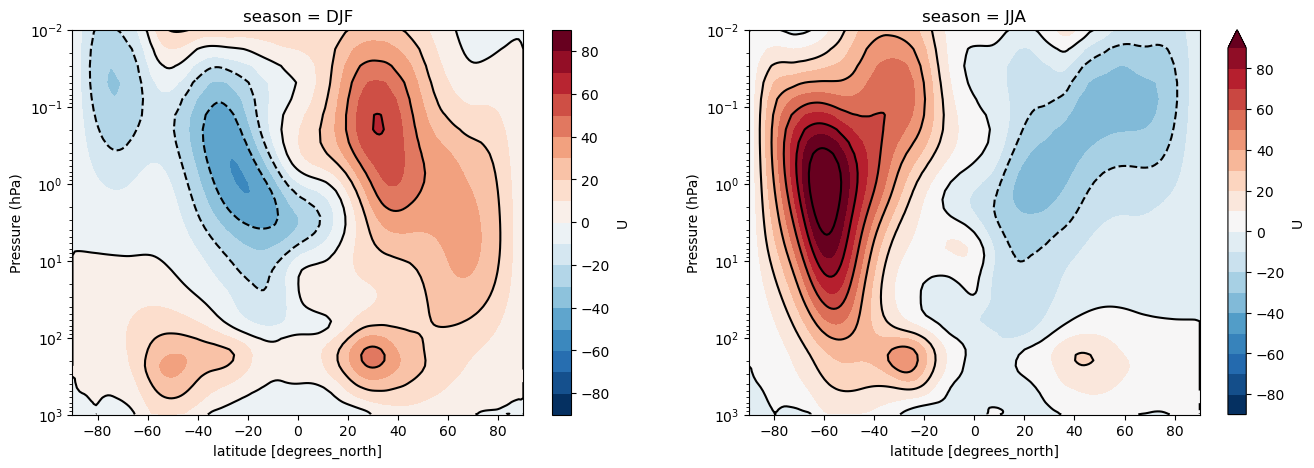

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004


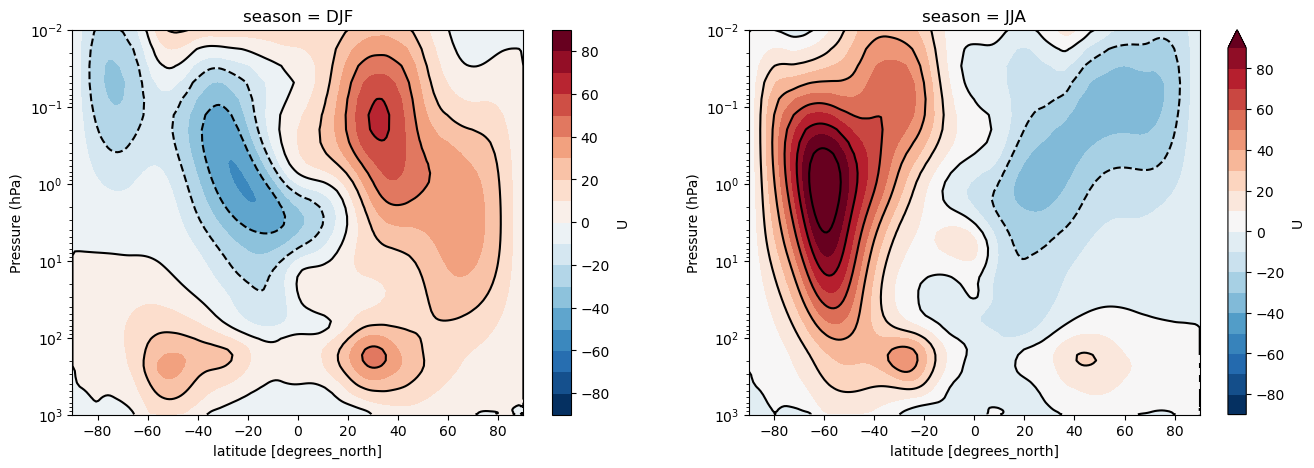

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001


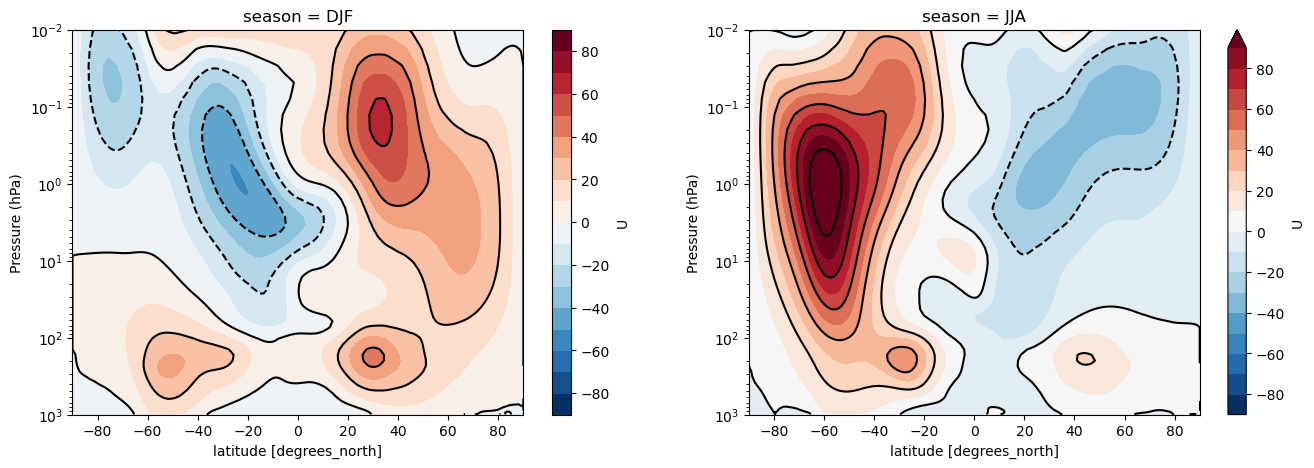

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


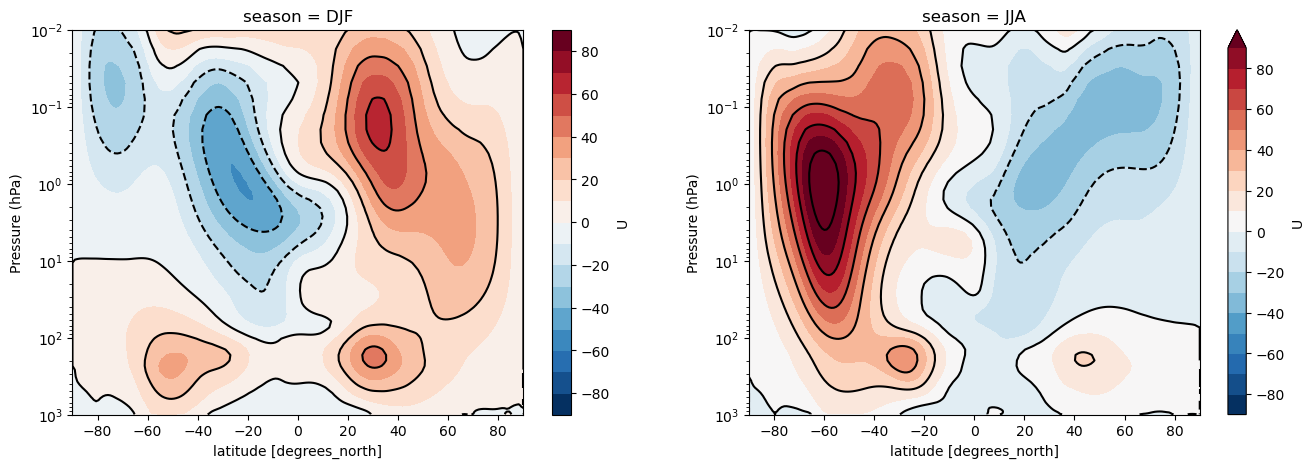

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002


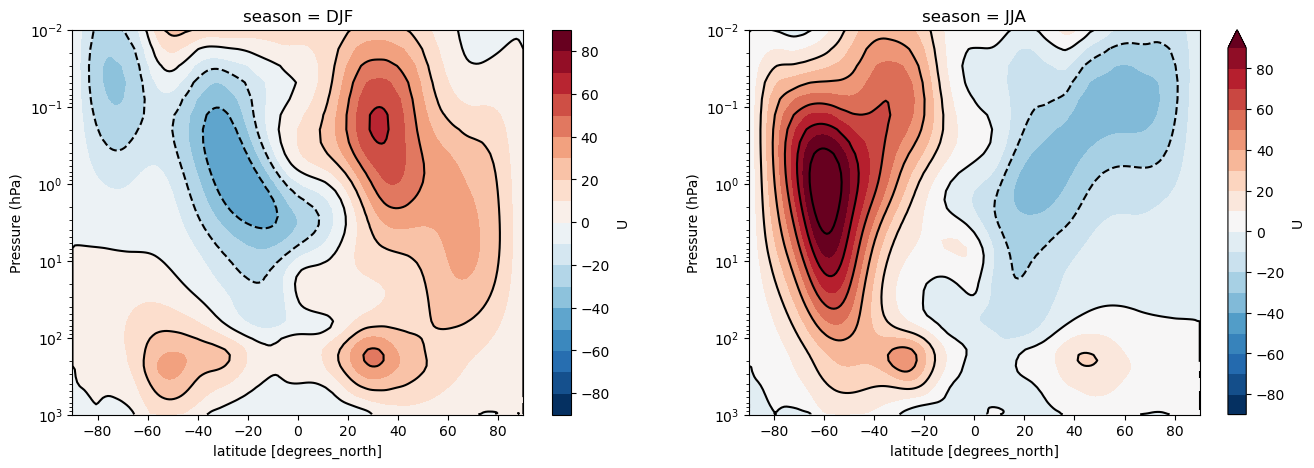

In [10]:
for case in hist_cases:
    print(case)
    ds = dsets[case]
    ds = xr.decode_cf(ds)
    ds = ds.sortby('time')
    
    ds = center_time(ds)
        
    u0 = ds['U'].sel(time=slice("2051-01", "2070-12")).mean(dim='lon').groupby('time.season').mean(dim='time')
    
    # plot DJF and JJA
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1,2,1)
    plot_u(u0.sel(season='DJF'))
    plt.subplot(1,2,2)
    plot_u(u0.sel(season='JJA'))
    plt.show()
    

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005


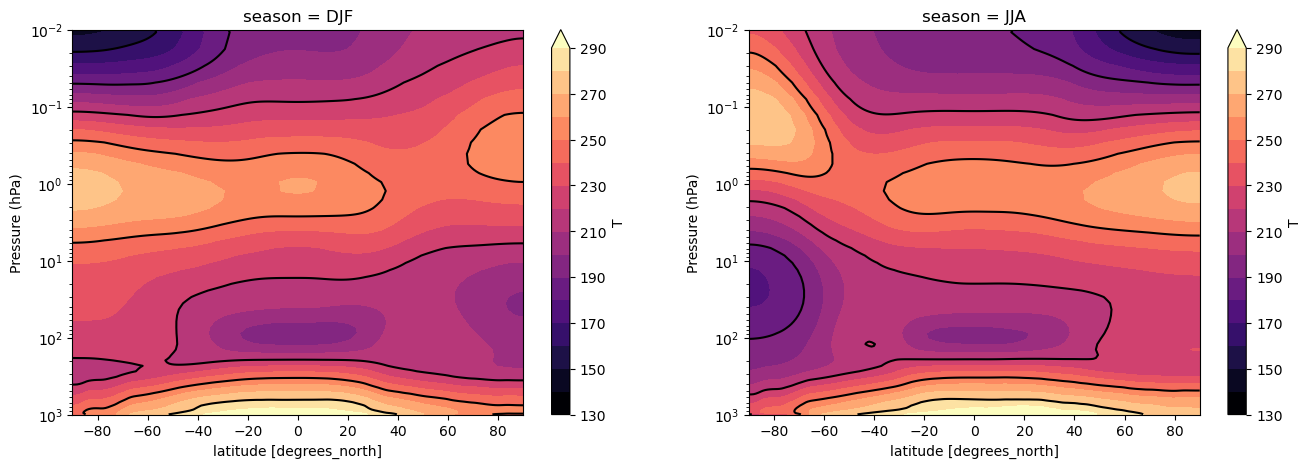

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004


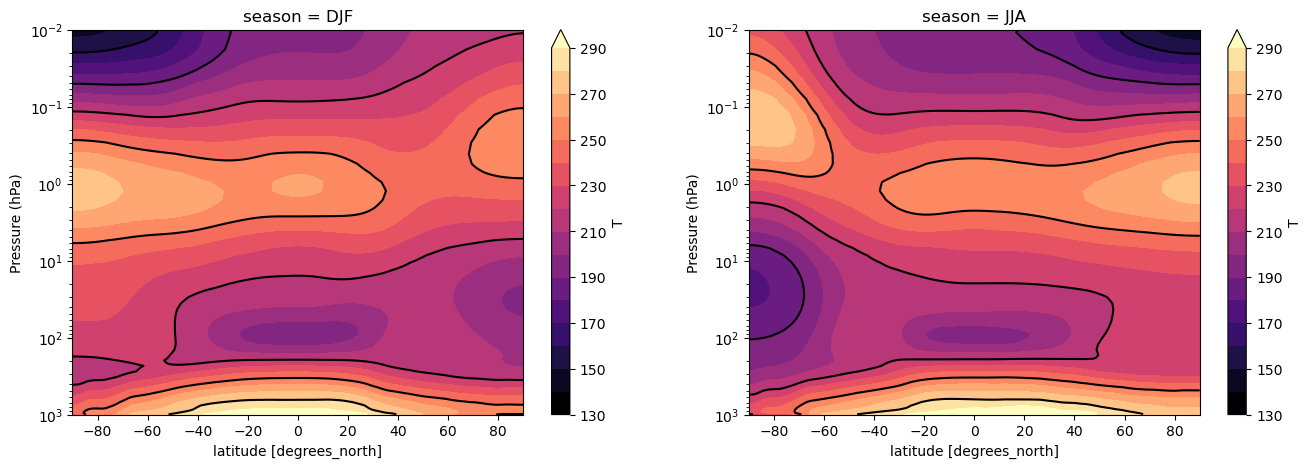

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001


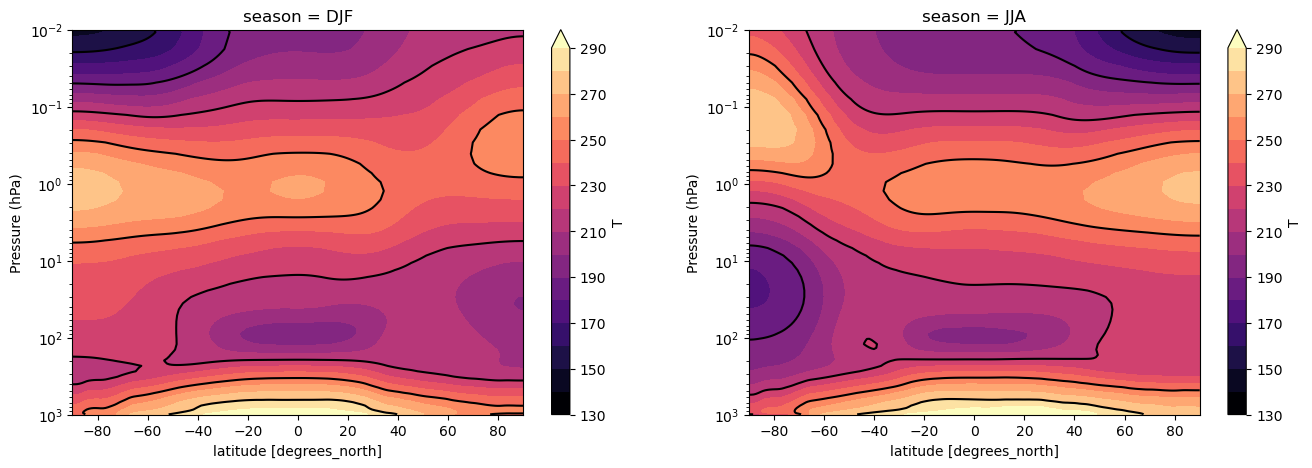

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


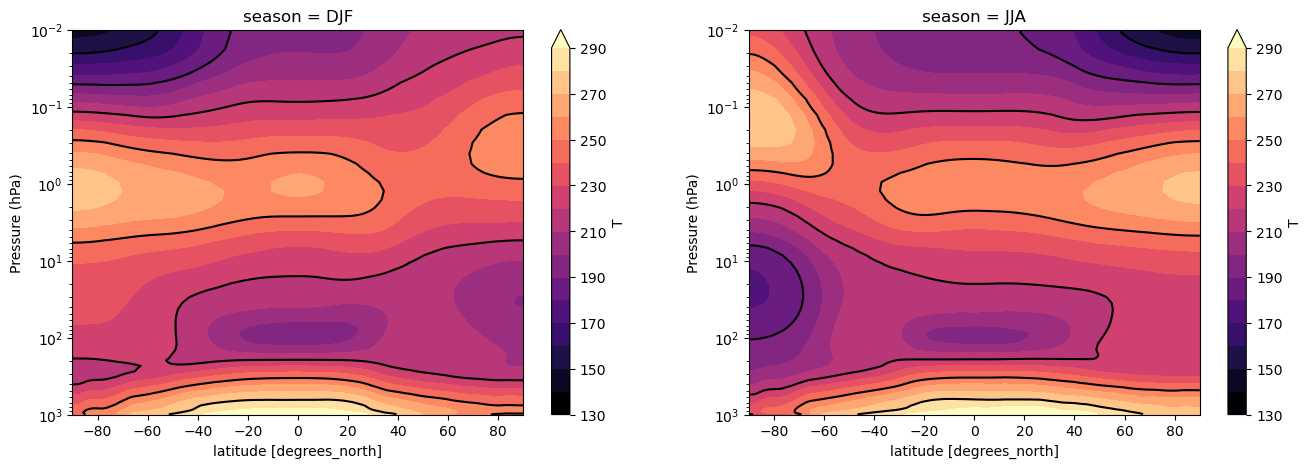

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002


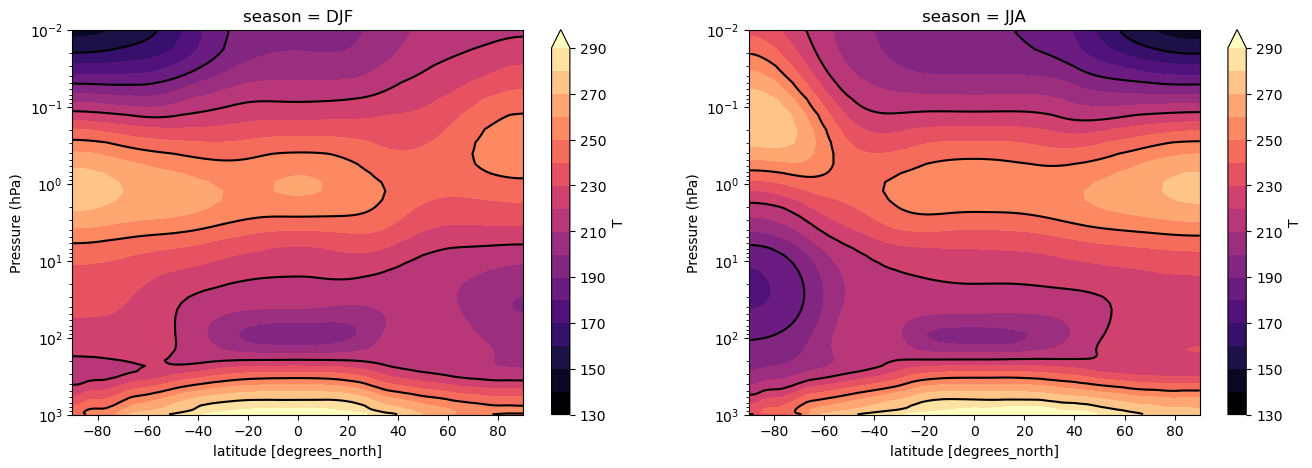

In [11]:
for case in hist_cases:
    print(case)
    ds = dsets[case]
    ds = xr.decode_cf(ds)
    ds = ds.sortby('time')
    
    ds = center_time(ds)
        
    t0 = ds['T'].sel(time=slice("2051-01", "2070-12")).mean(dim='lon').groupby('time.season').mean(dim='time')
    
    # plot DJF and JJA
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1,2,1)
    plot_t(t0.sel(season='DJF'))
    plt.subplot(1,2,2)
    plot_t(t0.sel(season='JJA'))
    plt.show()
    

In [12]:
u0

<xarray.DataArray 'U' (season: 4, lev: 70, lat: 192)>
dask.array<stack, shape=(4, 70, 192), dtype=float32, chunksize=(1, 70, 192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lev      (lev) float64 5.96e-06 9.827e-06 1.62e-05 ... 957.5 976.3 992.6
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.005


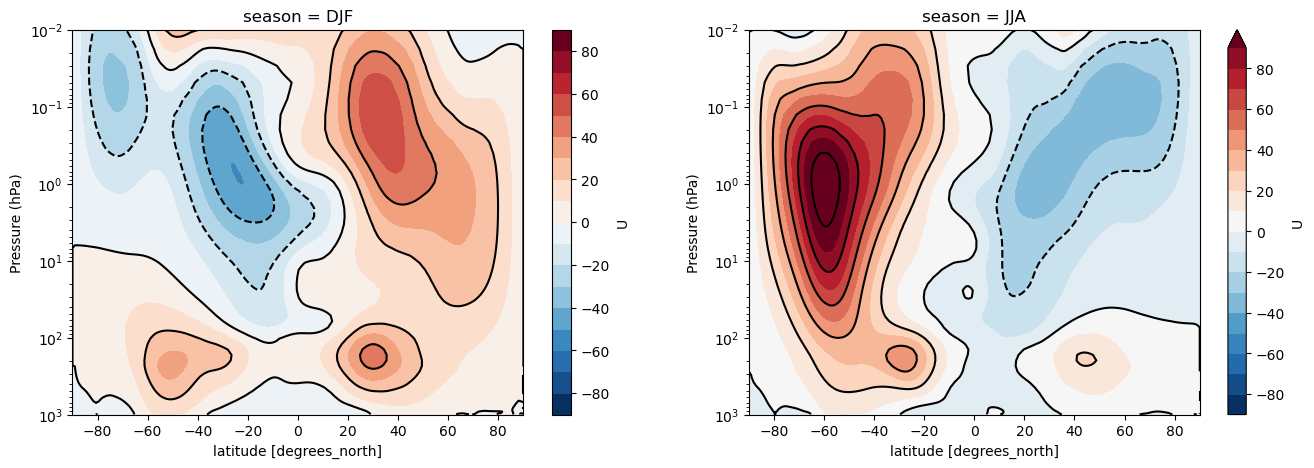

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.004


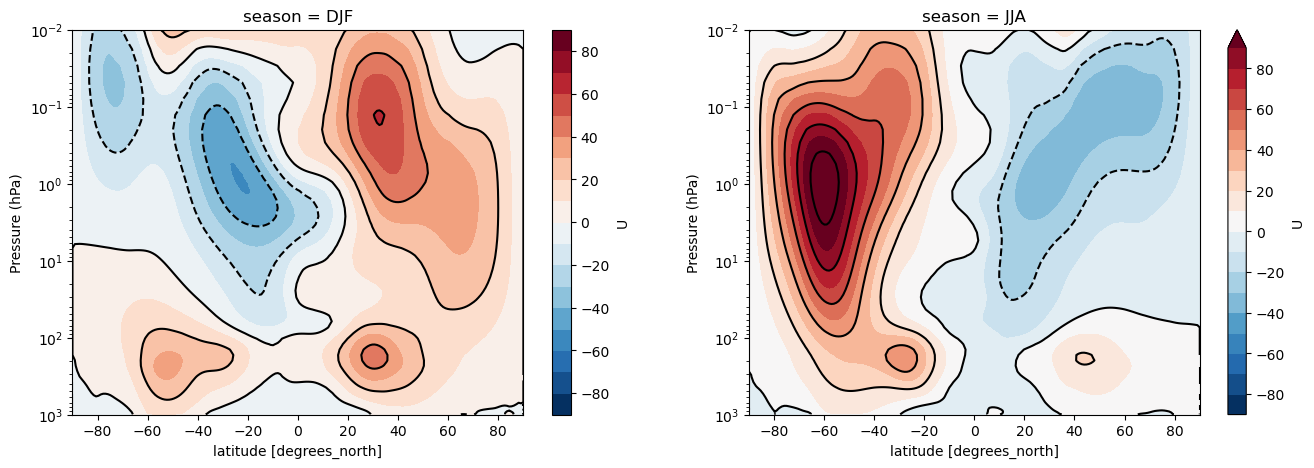

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.001


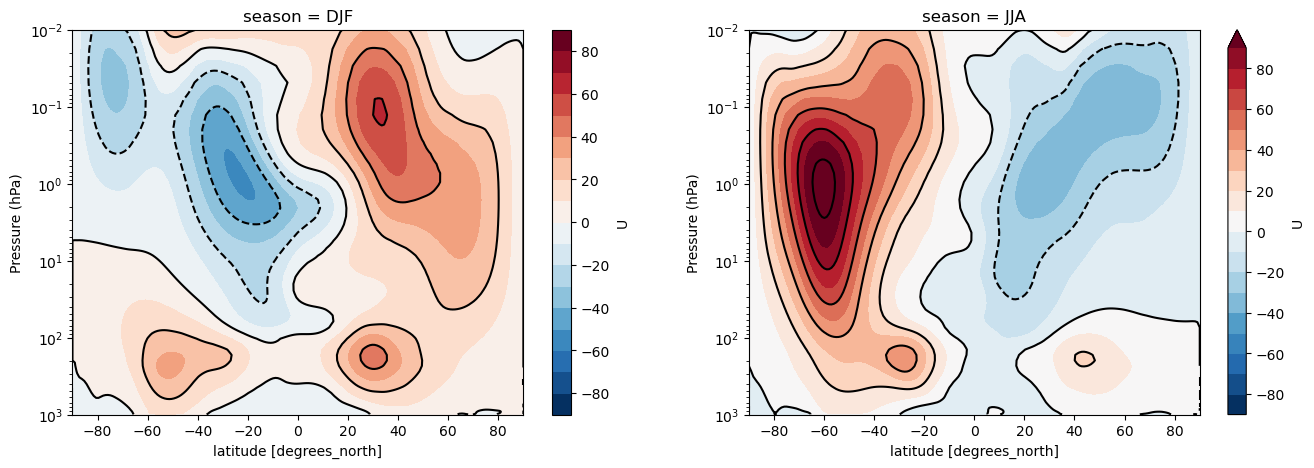

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.003


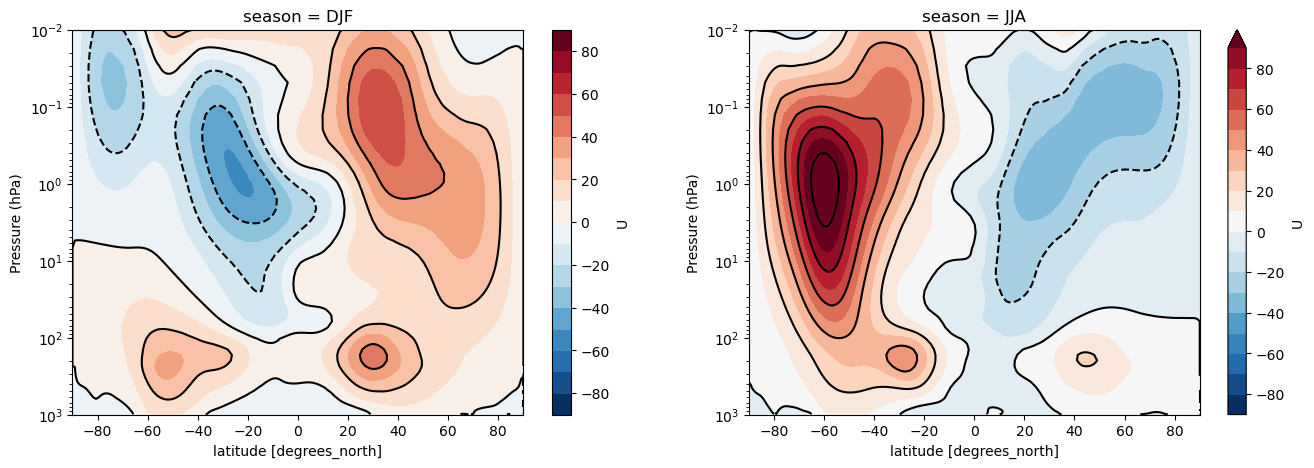

atm.cam.h0.b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.002


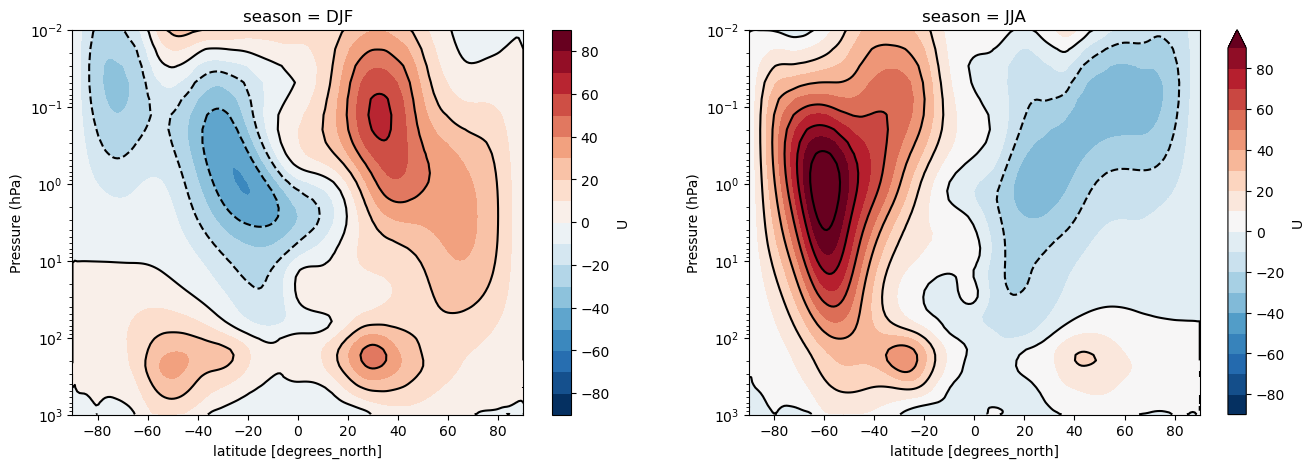

In [13]:
for case in hist_cases:
    print(case)
    ds = dsets[case]
    ds = xr.decode_cf(ds)
    ds = ds.sortby('time')
    
    ds = center_time(ds)
        
    u0 = ds['U'].sel(time=slice("2030-01", "2050-12")).mean(dim='lon').groupby('time.season').mean(dim='time')
    
    # plot DJF and JJA
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1,2,1)
    plot_u(u0.sel(season='DJF'))
    plt.subplot(1,2,2)
    plot_u(u0.sel(season='JJA'))
    plt.show()

In [16]:
cat2 = intake.open_esm_datastore(
    "/glade/work/marsh/intake-esm-catalogs/WACCM6-MA-1deg.json",
    ).search(
    variable=('U', 'T'),
    frequency=('month_1')
)
print(cat2.keys())

dict_keys(['atm.cam.h0.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h0.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918', 'atm.cam.h0.b.e21.BWmaCO2x4.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003'])


In [17]:
dsets2 = cat2.to_dataset_dict(cdf_kwargs={'chunks': {'time': 8}, 'decode_times': False})
dsets2.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


dict_keys(['atm.cam.h0.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002', 'atm.cam.h0.b.e21.BWmaCO2x4.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h0.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918', 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001'])

In [18]:
hist_cases2 = [key for key in list(cat2) if "HIST" in key]
print(len(hist_cases2))
cat2

3


,unique
component,1
stream,1
case,6
member_id,4
variable,2
start_time,15
end_time,15
time_range,16
long_name,2
units,2


atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003


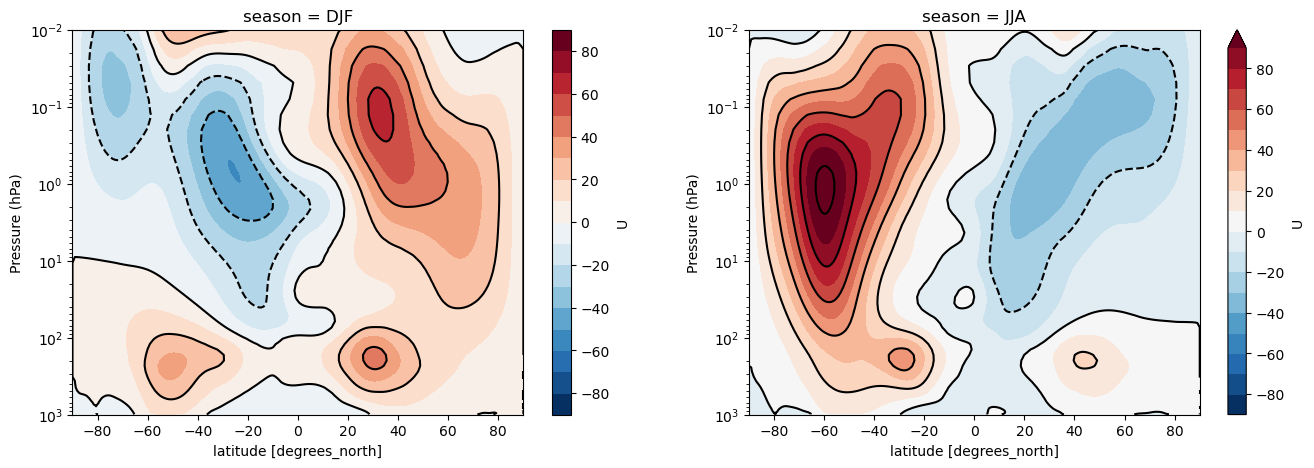

atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002


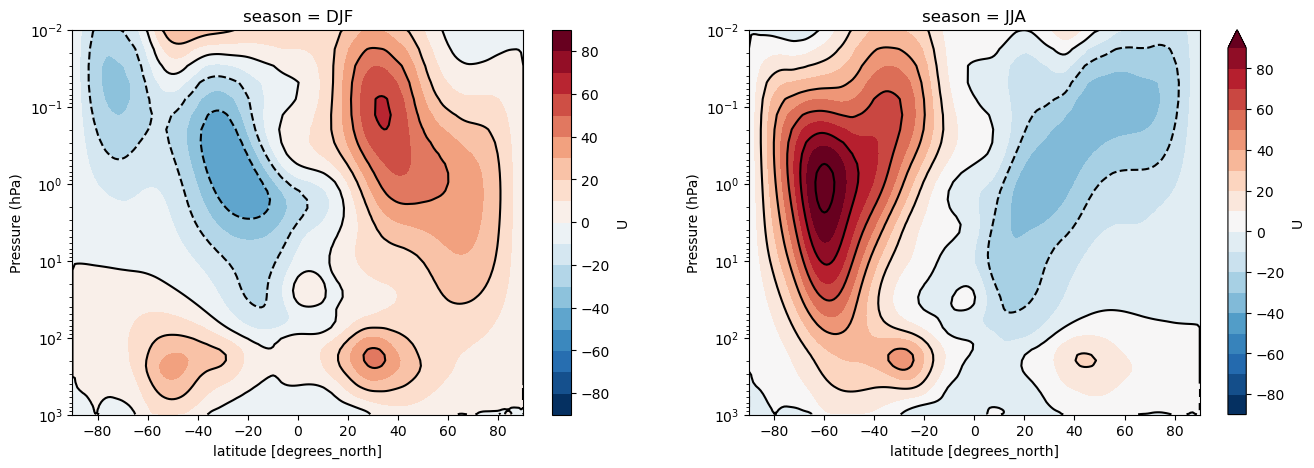

atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001


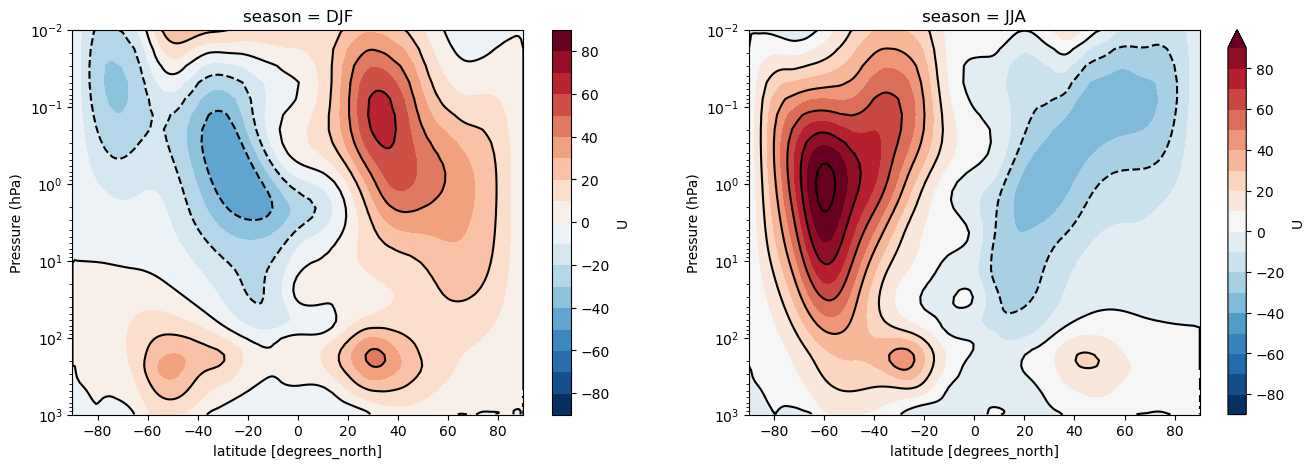

In [19]:
for case in hist_cases2:
    print(case)
    ds2 = dsets2[case]
    ds2 = xr.decode_cf(ds2)
    ds2 = ds2.sortby('time')
    
    ds2 = center_time(ds2)
        
    u1 = ds2['U'].sel(time=slice("1980-01", "2005-12")).mean(dim='lon').groupby('time.season').mean(dim='time')
    
    # plot DJF and JJA
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1,2,1)
    plot_u(u1.sel(season='DJF'))
    plt.subplot(1,2,2)
    plot_u(u1.sel(season='JJA'))
    plt.show()

In [75]:
hist_cases2

['atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001',
 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003',
 'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002']

atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001


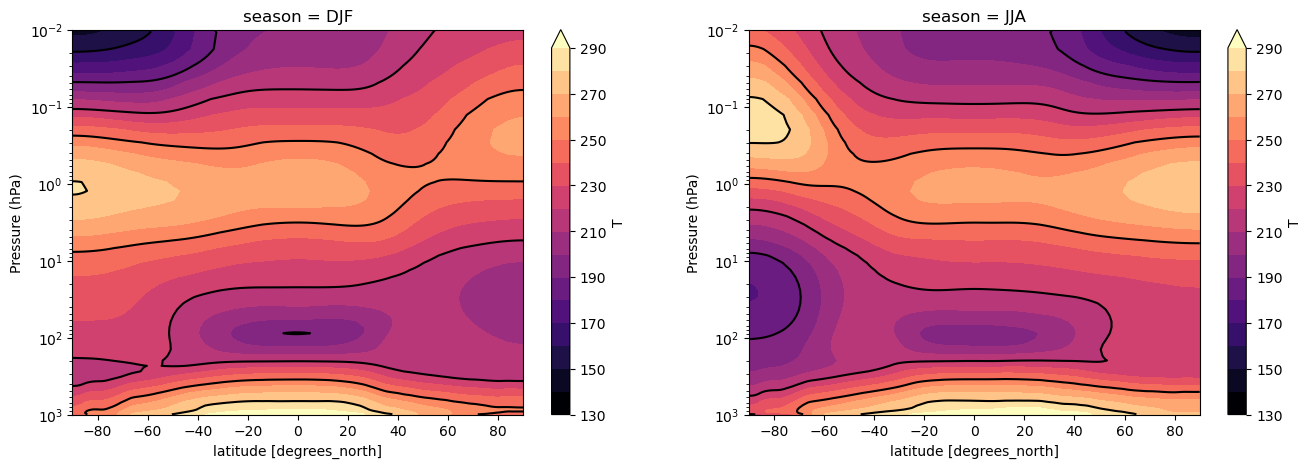

atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003


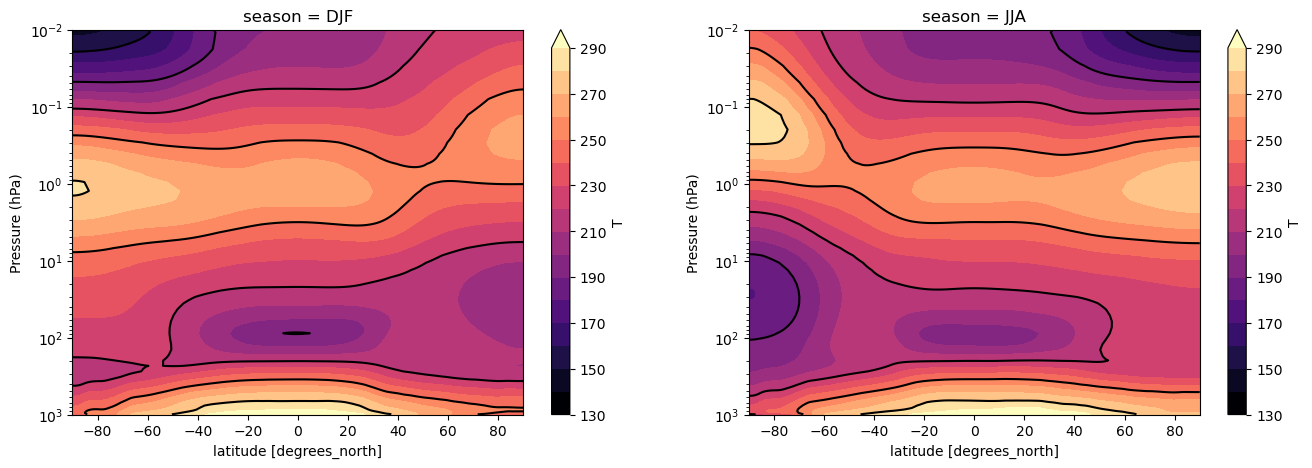

atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002


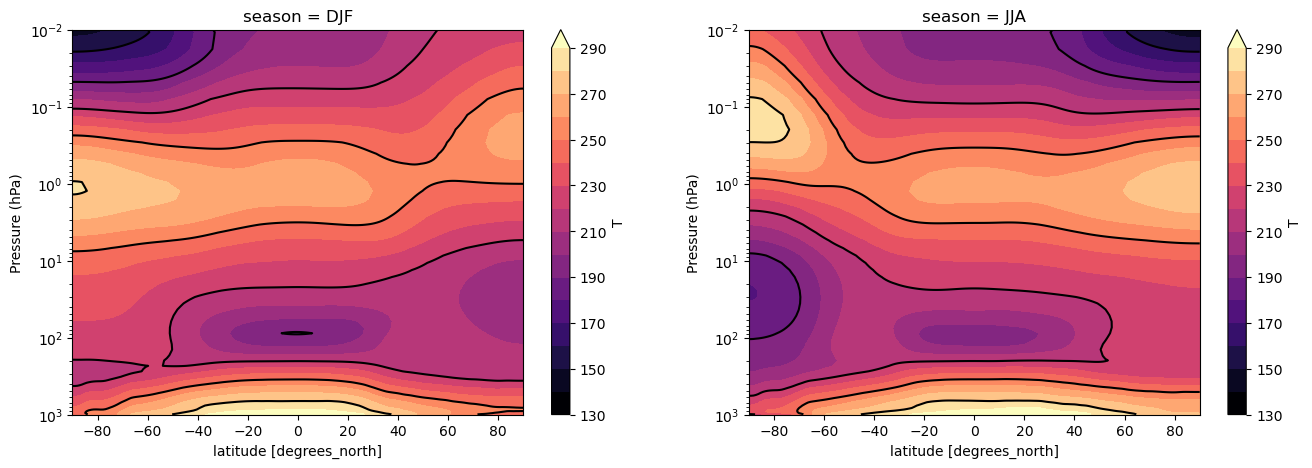

In [85]:
for case in hist_cases2:
    print(case)
    ds2 = dsets2[case]
    ds2 = xr.decode_cf(ds2)
    ds2 = ds2.sortby('time')
    
    ds2 = center_time(ds2)
        
    t0 = ds2['T'].sel(time=slice("1980-01", "2005-12")).mean(dim='lon').groupby('time.season').mean(dim='time')
    
    # plot DJF and JJA
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1,2,1)
    plot_t(t0.sel(season='DJF'))
    plt.subplot(1,2,2)
    plot_t(t0.sel(season='JJA'))
    plt.show()

In [76]:
dsets2['atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001']

<xarray.Dataset>
Dimensions:       (ilev: 71, lat: 192, lev: 70, lon: 288, nbnd: 2, time: 1980, zlon: 1)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 5.96e-06 9.827e-06 1.62e-05 ... 976.3 992.6
  * ilev          (ilev) float64 4.5e-06 7.42e-06 1.223e-05 ... 985.1 1e+03
  * time          (time) float64 31.0 59.0 90.0 ... 6.019e+04 6.022e+04
Dimensions without coordinates: nbnd
Data variables: (12/28)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    P0            float64 1e+05
    hyai          (ilev) float64 dask.array<chunksize=(71,), meta=np.ndarray>
    ...            ...
    f11vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    T             (time, lev, lat, lon) float32 dask.array<chunksize=(8, 70, 192, 288), meta=np.ndarray>
    U             (time, lev, lat, lon) float32 dask.array<chunksize=(8, 70, 192, 288), meta=np.ndarray>
Attributes:
    initial_file:            b.e21.BWma1850.f09_g17.release-cesm2.1.3.c202009...
    source:                  CAM
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    case:                    b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-M...
    Conventions:             CF-1.0
    logname:                 mmills
    time_period_freq:        month_1
    intake_esm_varname:      T\nU
    topography_file:         /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv...
    intake_esm_dataset_key:  atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2....

In [83]:
hist_cases2[0]

'atm.cam.h0.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001'